In [3]:
import xgboost

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

In [5]:

# Reload the dataset with the correct delimiter and sort it by date
df = pd.read_csv('data/train_egg_sales.csv', delimiter=';')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Create features based on the date
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['WeekDay']   = df['Date'].dt.weekday
df['Day_of_Week'] = df['Date'].dt.dayofweek
df['DayofYear'] = df['Date'].dt.dayofyear
df['Quarter']   = df['Date'].dt.quarter

# Drop the rows with missing values generated due to lag features
df = df.dropna()

# Show the first few rows of the enhanced dataset
df.head()


,Date,Egg Sales,Year,Month,Day,WeekDay,Day_of_Week,DayofYear,Quarter
0,1993-01-01,91,1993,1,1,4,4,1,1
1,1993-01-02,124,1993,1,2,5,5,2,1
2,1993-01-03,112,1993,1,3,6,6,3,1
3,1993-01-04,115,1993,1,4,0,0,4,1
4,1993-01-05,107,1993,1,5,1,1,5,1


In [6]:
a = df.groupby(['Year'])['Egg Sales'].mean()
df_new = pd.DataFrame([a.index, a.values]).T
df_new.columns=['Year','Egg Sales']
df_new

,Year,Egg Sales
0,1993.0,111.394521
1,1994.0,130.246575
2,1995.0,149.342466
3,1996.0,167.628415
4,1997.0,184.597260
5,1998.0,201.876712
6,1999.0,220.802740
7,2000.0,238.918033
8,2001.0,257.600000
9,2002.0,277.213699


In [7]:
x = df_new['Year'].values.reshape(-1, 1)

In [8]:
y = df_new['Egg Sales'].values.reshape(-1, 1)

In [9]:
model1 = LinearRegression()
model1.fit(x,y)
pred1 = model1.predict(x)
print(f'MSE= {mean_squared_error(y,pred1,squared=True)}')

testx = np.array([2022.0]).reshape(-1, 1)
predT = model1.predict(testx)
predT = predT[0][0]
print(f'Prediction sales in 2022 is {predT}')

MSE= 27.399787937226744
Prediction sales in 2022 is 637.1231650624322


In [10]:
def createFeature(df):
    df['Date']      = pd.to_datetime(df['Date'])
    df['Year']      = df['Date'].dt.year
    df['Month']     = df['Date'].dt.month
    df['Day']       = df['Date'].dt.day
    df['WeekDay']   = df['Date'].dt.weekday
    df['DayofYear'] = df['Date'].dt.dayofyear
    df['Quarter']   = df['Date'].dt.quarter
    return df

In [15]:
df.groupby('Year')['Egg Sales'].transform('mean')

0        111.394521
1        111.394521
2        111.394521
3        111.394521
4        111.394521
            ...    
10587    621.260274
10588    621.260274
10589    621.260274
10590    621.260274
10591    621.260274
Name: Egg Sales, Length: 10592, dtype: float64

In [18]:
def preprocessing(df):
    x = df.copy()
    x = createFeature(df)
    if "Egg Sales" in x.columns:
        x['Mean'] = x.groupby('Year')['Egg Sales'].transform('mean')
        y = x['Egg Sales']/x['Mean']
        x = x.drop(columns=['Date','Egg Sales','Mean'])
        return x,y
    else:
        x = x.drop(columns=['Date'])
        return x

In [19]:
test = pd.read_csv("data/test_egg_sales.csv", delimiter=';')

In [20]:
x,y = preprocessing(df)
testx = preprocessing(test)

In [23]:
x

,Year,Month,Day,WeekDay,Day_of_Week,DayofYear,Quarter
0,1993,1,1,4,4,1,1
1,1993,1,2,5,5,2,1
2,1993,1,3,6,6,3,1
3,1993,1,4,0,0,4,1
4,1993,1,5,1,1,5,1
...,...,...,...,...,...,...,...
10587,2021,12,27,0,0,361,4
10588,2021,12,28,1,1,362,4
10589,2021,12,29,2,2,363,4
10590,2021,12,30,3,3,364,4


In [21]:
model2 = XGBRegressor()
model2.fit(x,y)
pred2 = model2.predict(x)
print(f'MSE= {mean_squared_error(y,pred2,squared=True)}')
predT2 = model2.predict(testx)

ImportError: cannot import name 'Int64Index' from 'pandas' (/usr/local/lib/python3.10/site-packages/pandas/__init__.py)

In [22]:
x

,Year,Month,Day,WeekDay,Day_of_Week,DayofYear,Quarter
0,1993,1,1,4,4,1,1
1,1993,1,2,5,5,2,1
2,1993,1,3,6,6,3,1
3,1993,1,4,0,0,4,1
4,1993,1,5,1,1,5,1
...,...,...,...,...,...,...,...
10587,2021,12,27,0,0,361,4
10588,2021,12,28,1,1,362,4
10589,2021,12,29,2,2,363,4
10590,2021,12,30,3,3,364,4


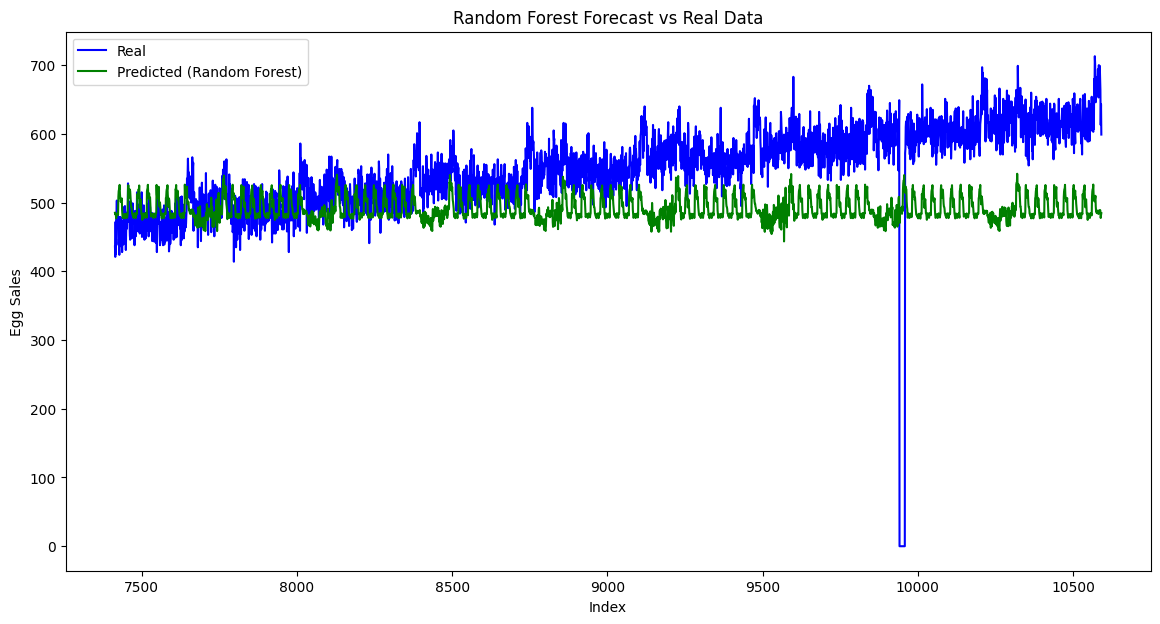

8129.740537696665

In [19]:

# Drop the 'Date' column as it's not needed for model training
df_model = df.drop(['Date'], axis=1)

# Extract features and target variable from the dataframe
X = df_model.drop(['Egg Sales'], axis=1)
y = df_model['Egg Sales']

# Split the data into training and testing sets (70% training and 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Calculate the Mean Squared Error (MSE)
mse_rf = mean_squared_error(y_test, y_pred_rf)

# Plotting the real and predicted values
plt.figure(figsize=(14, 7))
plt.plot(X_test.index, y_test, label='Real', color='blue')
plt.plot(X_test.index, y_pred_rf, label='Predicted (Random Forest)', color='green')
plt.xlabel('Index')
plt.ylabel('Egg Sales')
plt.title('Random Forest Forecast vs Real Data')
plt.legend()
plt.show()

mse_rf


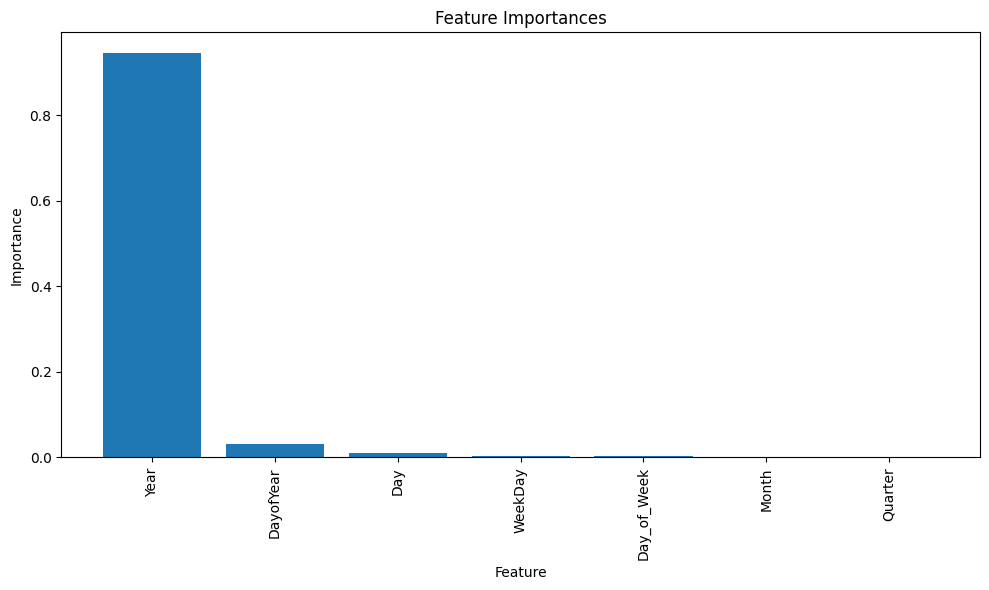

In [20]:
# Get feature importances from the RF model
importances = rf_model.feature_importances_
feature_names = rf_model.feature_names_in_
# Match feature importances with their corresponding names
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort features by importance (descending order)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance_df)), feature_importance_df['Importance'], tick_label=feature_importance_df['Feature'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility

# Show the plot
plt.tight_layout()
plt.show()